### Control law 

This notebook emulates a control laws where a set of 8 trucks are commanded to split at specific points in time. References to compute the platoon are in this case simulated not by a tactical strategy but virtually instead:

0. Setup model parameters (CAV)
1. Initial conditions for the model 
2. Reference conditions for the truck 
3. Launching the simulations for 

In [18]:
import numpy as np 
import pandas as pd 

# Plot 
import matplotlib.pyplot as plt 

import plotly as py 
from plotly.offline import init_notebook_mode, plot, iplot, iplot_mpl
import plotly.graph_objs as go 
init_notebook_mode(connected=True)


from ipywidgets import interactive, widgets
from IPython.display import display

#### Parameters

Simulation parameters

In [2]:
DT = 0.1 # Sample time 

Traffic parameters

In [3]:
# Truck parameters 
L_AVG = 18
G_X = 2
S_X = G_X + L_AVG
K_X = 1/S_X

# Traffic 
V_F = 25.0 # Max speed.
V_P = 20.0 # Platoon free flow
E  = 25.0*0.3 # Speed drop for relaxation 

U_MAX = 1.5 # Max. Acceleration
U_MIN = -1.5 # Min. Acceleration

In [21]:
def compute_parameters(G_X, C):
    """ Compute dynamically parameters based on G_X,C"""
    S_X = L_AVG + G_X 
    K_X = 1 / S_X        
    K_C = C / V_P    
    W  = C / (K_X - K_C)
    return (S_X, K_X, K_C, W)


def compute_FD(G_X, C):
    """Compute data for some predefined parameters """
    
    def compute_FD(k):
        """Compute k,q vector: Piecewise FD"""
        free_branch = lambda x: V_P * x
        cong_branch = lambda x: - (x-K_X) * W
        flow = np.piecewise(k, [k < K_C, k >= K_C], [free_branch, cong_branch])
        
        return flow    
    
    S_X, K_X, K_C, W  = compute_parameters(G_X, C)
    
    k = np.linspace(0, K_X, 100)
    q = compute_FD(k)
    return (k,q)

def create_layout(K_X, C):
    """ Create figure layout """
    layout = go.Layout(title = 'FUNDAMENTAL DIAGRAM',
                       yaxis = dict(title = 'Q',
                                    range = [0, C],
                                   ),
                       xaxis = dict(title = 'k', 
                                    range = [0, K_X],
                                   ),
                       width = 600, 
                       height = 600,
                    )
    return layout

layout = create_layout(0.05, 1 * 3600)
    
def update_plot(fr_space, capacity):
    """ Update plot within the figure"""    
    
    k, q = compute_FD(fr_space, capacity/3600)
    

    
    data = []        
    
    trace = go.Scatter(
        x = k, 
        y = q * 3600,
        mode = 'lines',
        name = 'Fundamental diagram',
        line = dict(
            shape = 'spline'
        )
    )
    data.append(trace)

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)
    

G_X_wg = widgets.FloatSlider(
        value=5,
        min=2,
        max=L_AVG-0.1,
        step=0.1,
        description='Front-rear Space gap',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        )

C_wg  = widgets.FloatSlider(
        value=2500,
        min=1800,
        max=3600-10,
        step=5,
        description='Capacity',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        )


interactive(update_plot, fr_space = G_X_wg, capacity = C_wg)

interactive(children=(FloatSlider(value=5.0, description='Front-rear Space gap', max=17.9, min=2.0, readout_fo…

In [22]:
G_X, C = G_X_wg.value, C_wg.value/3600
S_X, K_X, K_C, W  = compute_parameters(G_X, C)

TAU = 1/(K_X*W) # Time headway CAV 
RTE = TAU * (V_P+W) / V_P
G_T = G_X/V_P

Tau_wg = widgets.BoundedFloatText(
    value=TAU,
    min=0,
    max=10.0,
    step=0.1,
    description='Tau:',
    disabled=True
)
Rat_wg = widgets.BoundedFloatText(
    value=RTE,
    min=0,
    max=10.0,
    step=0.1,
    description='Rate:',
    disabled=True
)
gt_wg = widgets.BoundedFloatText(
    value=G_T,
    min=0,
    max=10.0,
    step=0.1,
    description='T_rf:',
    disabled=True
)


display(Tau_wg)
display(Rat_wg)
display(gt_wg)

BoundedFloatText(value=0.2899999999999999, description='Tau:', disabled=True, max=10.0, step=0.1)

BoundedFloatText(value=1.44, description='Rate:', disabled=True, max=10.0, step=0.1)

BoundedFloatText(value=0.25, description='T_rf:', disabled=True, max=10.0, step=0.1)

In [6]:
fSimTime = 10 * 60 # seconds
nSamples = int(fSimTime*1/DT)
aTime = np.arange(nSamples)*DT

#### Initial conditions for the trucks 

In [7]:
nTrucks = 8
aDims = (nSamples, nTrucks)

State initialization, space, speed, delta speed leader 

In [61]:
def set_initial_condition(mS0, mV0, mDV0):
    """ Setup initial conditions of experiment"""
    mS = np.zeros(aDims) # Spacing all trucks
    mV = np.zeros(aDims) # Speed 
    mDV = np.zeros(aDims) # Speed diference
    mS[0,:] = mS0
    mV[0,:] = mV0
    mDV[0,:]= mDV0
    return (mS, mV, mDV)

In [62]:
mS0 = np.ones(nTrucks) * S_X
mV0 = np.ones(nTrucks) * V_P
mDV0 = np.zeros(nTrucks)

mS, mV, mDV = set_initial_condition(mS0, mV0, mDV0)

In [63]:
nH = 50

#### Reference conditions for trucks


In [10]:
iYieldTruck = range(nTrucks)

# Splits are predefined at some specific points in time (merging times)
iIdxTimeSplit = [int(t*60*1/DT) for t in (3,6,9)]
fTimeSplit = [aTime[i] for i in iIdxTimeSplit ]
fValueTimeHwyInitial = [0.9,0.9]
fValueTimeHwyEnd = [1.8,0]
fValueTimeHwy = [(st,ed) for st, ed in zip(fValueTimeHwyInitial,fValueTimeHwyEnd)]


mEvents = [{'id':i, 'tm': tm, 'tg': tg} for i in iYieldTruck for tm in fTimeSplit for tg in fValueTimeHwy]


mRefSpacing = 1

To do:

* Create a single scenario (ref single split) - Func
* Create a scenario (2 splits and reintegrations)  - Func
* Run a single simulation Func( initial_cond, leaders_acc, theta) 

In [11]:
def create_ref(dEvent, Teq):
    """Creates a reference matrix for the control"""
    
    def anticipation_time(T_0, T_F):
        """Computes the anticipation time according to TRB 2018"""
        T_a = E / 2 * (U_MIN-U_MAX)/ (U_MIN * U_MAX) + (V_P + W) / E * (T_F - T_0)
        return T_a    
    
    def get_sigmoid(v0, vf, yld, ant):
        """ Computes a sigmoid function with rise time equivalent to anticipation time"""
        aNewTime = 8 * (aTime - (yld + ant/2)) / ant
        return v0 + (vf-v0) * 1 / (1 + np.exp(- aNewTime))
    
    mRef = np.ones(aDims) * Teq
    iIdTruck = dEvent['id']
    fMrgTime = dEvent['tm']
    T_0, T_X = dEvent['tg']
    _T_0, _T_X = (T_X, T_0) if T_0 > T_X else (T_0, T_X)
    fAntTime = anticipation_time(_T_0, _T_X)
    fYldTime = fMrgTime - fAntTime
    
    mRef[:,iIdTruck] = get_sigmoid(T_0, T_X, fYldTime, fAntTime)        
    
    print(f'Anticipation time: {fAntTime}')
    print(f'Yielding time: {fYldTime}')
    
    return mRef

In [80]:
def initialize_mpc(mS0, mV0, mDV0):
    """ Initialize internal variables control"""
    aDimMPC = (nH,nTrucks)
    m_S, m_V, m_DV, m_LS, m_LV, m_U = (np.zeros(aDimMPC) for i in range(6))
    m_S[0] = mS0
    m_V[0] = mV0
    m_DV[0] = mDV0
    return m_S, m_V, m_DV, m_LS, m_LV, m_U

In [82]:
def compute_control(mX0, mRef):
    """ Computes a control based on mX0 and the reference mRef"""
    
    def forward_evolution(U):
        """ Compute the evolution in a window of time"""
        for i, u_s, du in zip(range(nH), U_star, DU):
            if i < len(S)-1:
                DV[i+1] = DV[i] + DT * du
                S[i+1] = S[i] + DT * DV[i]
                V[i+1] = V[i] + DT * u_s
        return S, V, DV           
    
    def backward_evolution(X):
        """ Compute the bakckward evolution"""
        
        return LS, LV
        
    
    _m_S, _m_V, _m_DV, _m_LS, _m_LV, m_U = initialize_mpc(*mX0)

    
    # Parameters
    C1 = 0.1
    C2 = 1
    C3 = 0.5
    ALPHA = 0.01
    EPS = 0.1
    
    # Convergence
    error = 100
    bSuccess = 2
    N = 10000  # number of iterations
    
    step = iter(range(N))    
    
    while (error > EPS) and (bSuccess > 0):
        try:
            next(step)
            U_star = -Lv/(2*C3)
            U_star = np.clip(U_star, U_MIN, U_MAX)

            DU = U_star[:, ldr_pos]-U_star[:] + U_ext

            # Forward evolution
            for i, u_s, du in zip(range(h), U_star, DU):
                if i < len(S)-1:
                    DV[i+1] = DV[i] + DT * du
                    S[i+1] = S[i] + DT * DV[i]
                    V[i+1] = V[i] + DT * u_s

            Sref = V * Tgref + 1/KC

    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-82-7d53037a473b>, line 47)

In [14]:
def update_cd(mS):
    """ Update drag coefficient"""
    _Cd_max = 1.55
    
    return 

Test zone

Anticipation time: 16.917241379310347
Yielding time: 163.08275862068965


(150, 180)

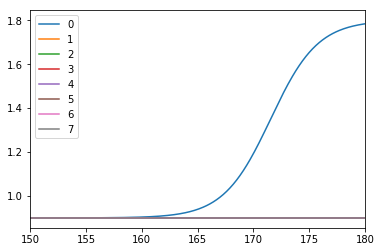

In [19]:
x = pd.DataFrame(create_ref(mEvents[0],0.9), index = aTime)
x.plot()
plt.xlim((150, 180))